# 필요한 패키지 임포트

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import time

# 데이터 불러오기

In [25]:
df_oil = pd.read_csv("oil.csv")
df_holidays = pd.read_csv("holidays_events.csv")
df_train = pd.read_csv("train.csv",index_col='id')
df_stores = pd.read_csv("stores.csv")
df_transactions = pd.read_csv("transactions.csv")
df_test = pd.read_csv("test.csv",index_col='id')

# 데이터 살펴보기

## train data

In [4]:
df_train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


- sotre_nbr : 물건이 팔린 가게를 구분하는 factor
- family : 팔린 물건의 유형
- sales : 주어진 date/store_nbr/family 에 대한 총 판매량
- onpromotion : 해당 날짜에 가게에서 프로모션 진행중이던 상품의 수

## test data

In [82]:
df_test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


- 형식은 train 데이터와 같으며, 우리가 예측할 것은 각 제품에 대한 판매량이다.(targe sales)
- test 데이터는 train data의 마지막 데이터로부터 15일 뒤의 데이터이다.

## store data

In [7]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


- 가게별 위치하고있는 도시/주 그리고 유형을 나타내는 데이터이다.
- cluster는 비슷한 가게끼리 grouping 해둔 열이다.

In [12]:
df_stores['cluster'].unique()

array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17],
      dtype=int64)

In [9]:
df_stores['cluster']

0     13
1     13
2      8
3      9
4      4
5     13
6      8
7      8
8      6
9     15
10     6
11    15
12    15
13     7
14    15
15     3
16    12
17    16
18    15
19     6
20     6
21     7
22     9
23     1
24     1
25    10
26     1
27    10
28    10
29     3
30    10
31     3
32     3
33     6
34     3
35    10
36     2
37     4
38     6
39     3
40     4
41     2
42    10
43     5
44    11
45    14
46    14
47    14
48    11
49    14
50    17
51    11
52    13
53     3
Name: cluster, dtype: int64

## oil data

In [73]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


- test 데이터와 train 데이터의 날짜를 모두 포함해, 그 날짜별 기름값을 나타내는 데이터이다.
- 에콰도르는 기름과 경제적 상황이 매우 연관성이 높은 곳들이므로, 판매량과 기름값이 연관성이 있을 수 있다.
- NaN 값이 있는 것을 보아 임퓨팅이 필요해보인다.

## holiday data

In [7]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


- transferred : 특정 이유로 공휴일을 옮긴경우를 의미한다. 

holiday의 경우 판매량에 직접적인 연관성을 가지고 있을 것이라고 예상해볼 수 있다.(마트가 열지않는 날에는 당연히 판매량이 0일 것임)

In [16]:
df_holidays['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

- holiday : 공휴일
- transfer : 공휴일이 옮겨졌음을 의미(따라서 transfer이 적혀있는 날은 공휴일이 아님을 의미)
- additional : 추가된 공휴일(ex. 크리스마스이브를 공휴일로 추가)
- bridge : 우리나라의 대체공휴일 생각하면 될듯..?
- workday : bridge에서 추가된 공휴일을 대체하기 위해 원래 일하는 날이 아닌데 일하는 날로 편성한 것

## transaction data

In [24]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


각 날짜별 가게별 총거래량을 나타내는 데이터이다.

# 결측값 확인

kaggle을 참조하여 데이터에 있는 missing의 수, 퍼센트, 최댓값과 최솟값, unique한 데이터 안의 원소의 수를 알아볼 것이다.

In [3]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    
    return summ

유의할 점은 당연히 문자형 데이터가 담겨있는 변수의 경우 min과 max의 값이 NaN이 나올 것이므로 신경쓰지 말아야 할 것이다.

## oil data

In [19]:
summary(df_oil)

data shape: (1218, 2)


,data type,#missing,%missing,#unique,min,max
date,object,0,0.000000,1218,NaN,NaN
dcoilwtico,float64,43,3.530378,998,26.19,110.62


결측값이 존재하고있으므로, 임퓨팅을 진행하기위해 아래의 아이디어를 생각해볼 수 있을 것이다.
"df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate()"
위의 코드를 돌려보면 하나의 값(첫 번째 값)을 제외하고는 임퓨팅 되는것을 확인할 수 있고, 임의로 첫 번째값은 두 번째값과 같은 값으로 대체해 NaN값을 처리할 수 있을 것이다.(기름값이 첫 째날과 둘 째날은 변함이 없었다고 생각해볼 수 있을 것임.)

## store data

In [22]:
summary(df_stores) 

data shape: (54, 5)


,data type,#missing,%missing,#unique,min,max
store_nbr,int64,0,0.0,54,1.0,54.0
city,object,0,0.0,22,NaN,NaN
state,object,0,0.0,16,NaN,NaN
type,object,0,0.0,5,NaN,NaN
cluster,int64,0,0.0,17,1.0,17.0


## train data

In [21]:
summary(df_train)

data shape: (3000888, 5)


,data type,#missing,%missing,#unique,min,max
date,object,0,0.0,1684,NaN,NaN
store_nbr,int64,0,0.0,54,1.0,54.0
family,object,0,0.0,33,NaN,NaN
sales,float64,0,0.0,379610,0.0,124717.0
onpromotion,int64,0,0.0,362,0.0,741.0


## test data

In [5]:
summary(df_test)

data shape: (28512, 4)


,data type,#missing,%missing,#unique,min,max
date,object,0,0.0,16,NaN,NaN
store_nbr,int64,0,0.0,54,1.0,54.0
family,object,0,0.0,33,NaN,NaN
onpromotion,int64,0,0.0,212,0.0,646.0


## transaction data

In [26]:
summary(df_transactions)

data shape: (83488, 3)


,data type,#missing,%missing,#unique,min,max
date,object,0,0.0,1682,NaN,NaN
store_nbr,int64,0,0.0,54,1.0,54.0
transactions,int64,0,0.0,4993,5.0,8359.0


# 데이터 시각화

여기서부터는 kaggle의 코드를 좀 많이 참고하였다..

## oil price와 sales 사이의 연관성

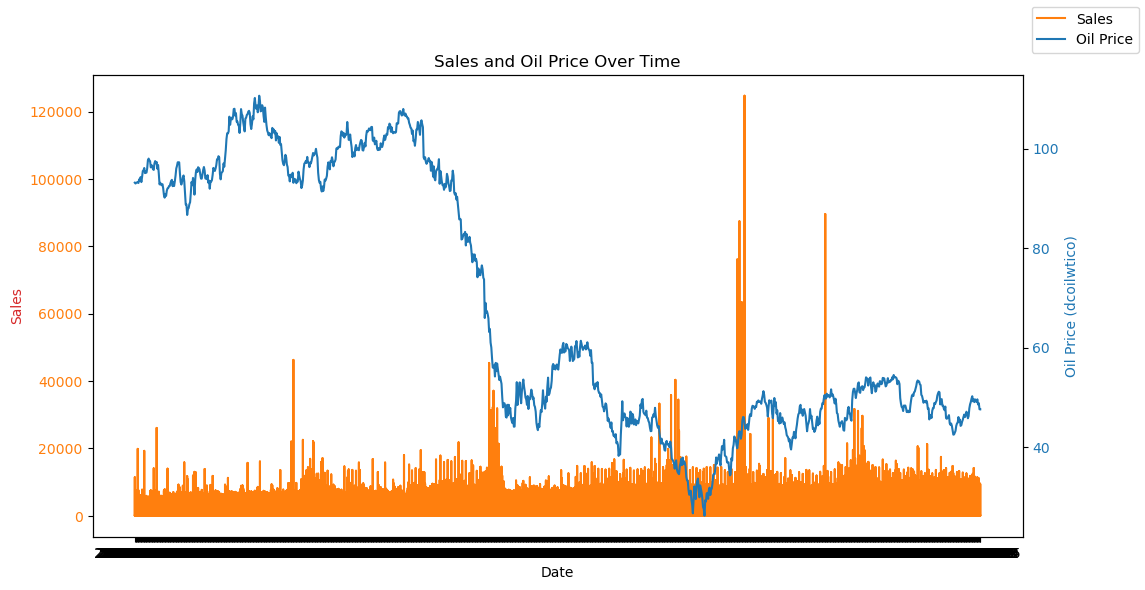

In [4]:
merged_df = pd.merge(df_train, df_oil, on='date', how='left')

oil_sales = merged_df.groupby('date')['sales'].sum().reset_index()

# drop missing data
merged_df.dropna(subset=['sales', 'dcoilwtico'], inplace=True)

fig, ax1 = plt.subplots(figsize=(12, 6))

# plot for sales
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales', color='tab:red')
sales_line, = ax1.plot(merged_df['date'], merged_df['sales'], color='tab:orange', label='Sales')
ax1.tick_params(axis='y', labelcolor='tab:orange')

# plot for oil price
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price (dcoilwtico)', color='tab:blue')
oil_line, = ax2.plot(merged_df['date'], merged_df['dcoilwtico'], color='tab:blue', label='Oil Price')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Sales and Oil Price Over Time')
fig.legend(handles=[sales_line, oil_line], loc='upper right')
plt.show()

기름값이 제일 많이 치솟아있는 부분에서 판매량이 저조하기는하지만, 기름값 때문에 판매량이 저조해졌기보다는 이미 판매량이 하향세를 보이고 있었기 때문에 기름값과 판매량 사이에는 큰 연관성이 없다고 판단할 수 있다.(기름가격이 오른것이 바로 반영되지는 않을 수도 있음, shift를 해 볼 필요성이 있긴함)

## promotion과 sales 사이의 연관성

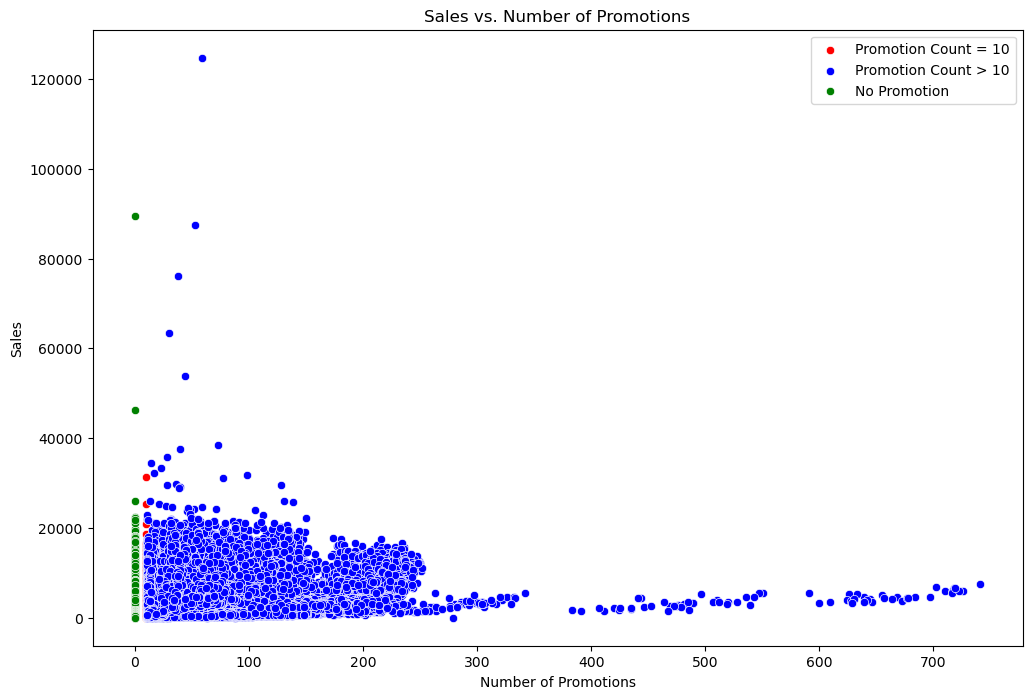

In [5]:
plt.figure(figsize=(12, 8))
# The number of 'onpromotion' is bigger than 10
sns.scatterplot(x='onpromotion', y='sales', data=df_train[df_train['onpromotion'] == 10], color='red', label='Promotion Count = 10')
# The number of 'onpromotion' is less than 10
sns.scatterplot(x='onpromotion', y='sales', data=df_train[df_train['onpromotion'] > 10], color='blue', label='Promotion Count > 10')
# The number of 'onpromotion' is 0
sns.scatterplot(x='onpromotion', y='sales', data=df_train[df_train['onpromotion'] == 0], color='green', label='No Promotion')
plt.title('Sales vs. Number of Promotions')
plt.xlabel('Number of Promotions')
plt.ylabel('Sales')
plt.legend()
plt.show()

물론 promotion의 기준을 다르게 잡았을 경우 위와는 다르게 나올 수 있지만 위의 결과만으로도 크게 연관성이 없다는 것을 확인할 수 있다. 특히 promoiton이 아예 없던 곳(초록색 점)에서도 다양한 판매량값이 분포되어있고, promotion이 400이상인 곳을 살펴보면 판매량이 점점 증가한다고 생각할 수는 있지만 전체적으로 보면 오히려 판매량이 감소하였다.

## holiday와 sales 사이의 연관성

### holiday type

물론 transferred된 holiday는 재정의되어야 할 것이지만, 여기서는 잠시 무시하고, holiday의 type별 판매량 평균 그래프를 살펴보고자한다.

그러기위해서 가장먼저 holiday의 type별로 그에 해당하는 것은 1, 아닌것은 0으로 원핫인코딩을 할 것이다.

In [26]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_train['date'] = pd.to_datetime(df_train['date'])

holiday_types = ['Holiday', 'Additional', 'Bridge', 'Work Day', 'Transfer', 'Event']
for holiday_type in holiday_types:
    df_holidays[holiday_type] = (df_holidays['type'] == holiday_type).astype(int)

df_train = pd.merge(df_train, df_holidays[['date'] + holiday_types], on='date', how='left')
df_train[holiday_types] = df_train[holiday_types].fillna(0).astype(int)

df_train.head()

,date,store_nbr,family,sales,onpromotion,Holiday,Additional,Bridge,Work Day,Transfer,Event
0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,0,0,0,0,0
1,2013-01-01,1,BABY CARE,0.0,0,1,0,0,0,0,0
2,2013-01-01,1,BEAUTY,0.0,0,1,0,0,0,0,0
3,2013-01-01,1,BEVERAGES,0.0,0,1,0,0,0,0,0
4,2013-01-01,1,BOOKS,0.0,0,1,0,0,0,0,0


In [15]:
tot = {}
holiday_types = ['Holiday', 'Additional', 'Bridge', 'Work Day', 'Transfer', 'Event']
for holiday_type in holiday_types:
    tot[holiday_type] = (df_holidays['type']==holiday_type).sum()

In [21]:
tot

{'Holiday': 221,
 'Additional': 51,
 'Bridge': 5,
 'Work Day': 5,
 'Transfer': 12,
 'Event': 56}

bridge와 workday는 서로 상호보완관계이므로 같은 수로 나타나며, holiday의 비율이 가장 높고, 그 외 나머지 date들은 모두 공휴일이 아닌 데이터(대다수)임을 확인할 수 있었다.

이제 holiday type별 판매량 평균을 나타내보자.

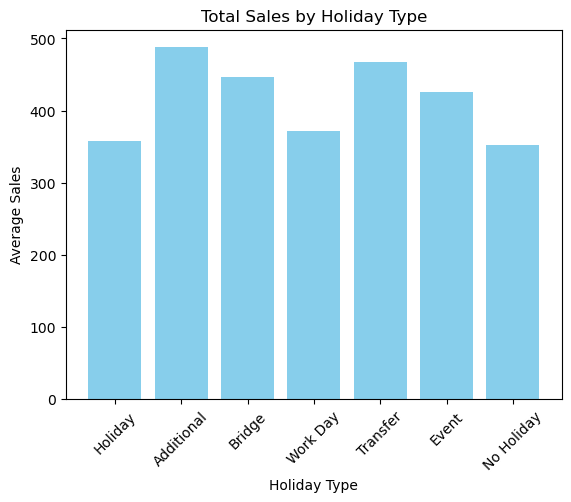

In [48]:
holiday_sales_means = {}

for holiday_type in holiday_types:
    filtered_rows = df_train[df_train[holiday_type] == 1.0]
    holiday_sales_means[holiday_type] = filtered_rows['sales'].mean()

no_holiday_data = df_train[(df_train[holiday_types].sum(axis=1) == 0)]
holiday_sales_means['No Holiday'] = no_holiday_data['sales'].mean()


fig, ax = plt.subplots()
ax.bar(holiday_sales_means.keys(), holiday_sales_means.values(), color='skyblue')
ax.set_title('Total Sales by Holiday Type')
ax.set_xlabel('Holiday Type')
ax.set_ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()

holiday, work day, no holiday 보다는 additional, bridge, transfer, event에서 판매량이 조금 더 많이 나타나 있는 것을 확인할 수 있을 것이다.(공휴일이 아니거나, workday에는 당연히 일한다고 가게 물품의 판매량이 저조할 것이고, 공휴일은 마트가 쉬는날이였거나 마트가 열었지만 쉬는날이라 귀찮아서 마트를 가지않는 것이 아닐까?/ 그리고 추가된 공휴일, 대체공휴일, 이벤트성 공휴일 등은 원래 공휴일이 아니였기에 마트가 쉬지않을 확률이 높고 일반 공휴일에는 집에서 쉬고 이런 기대하지않았던 공휴일에는 쇼핑을 하는 것이 아닐까?)

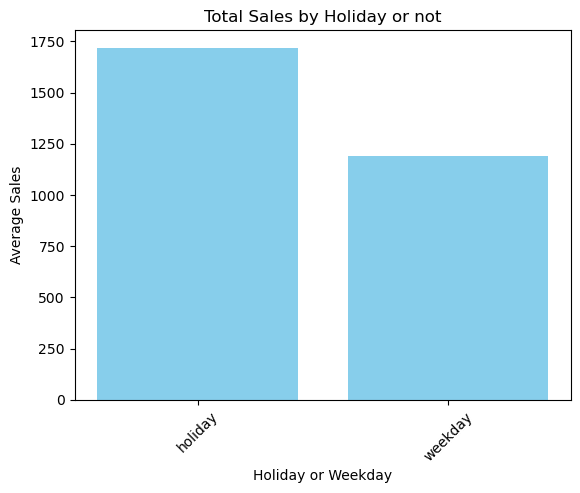

In [71]:
holiday_sales_means2 = {}
holiday_sales_means2['holiday'] = holiday_sales_means['Holiday']+holiday_sales_means['Additional']+holiday_sales_means['Bridge']+holiday_sales_means['Event']
holiday_sales_means2['weekday'] = holiday_sales_means['Work Day']+ holiday_sales_means['Transfer']+ holiday_sales_means['No Holiday']

fig, ax = plt.subplots()
ax.bar(holiday_sales_means2.keys(), holiday_sales_means2.values(), color='skyblue')
ax.set_title('Total Sales by Holiday or not')
ax.set_xlabel('Holiday or Weekday')
ax.set_ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()

### holiday locale

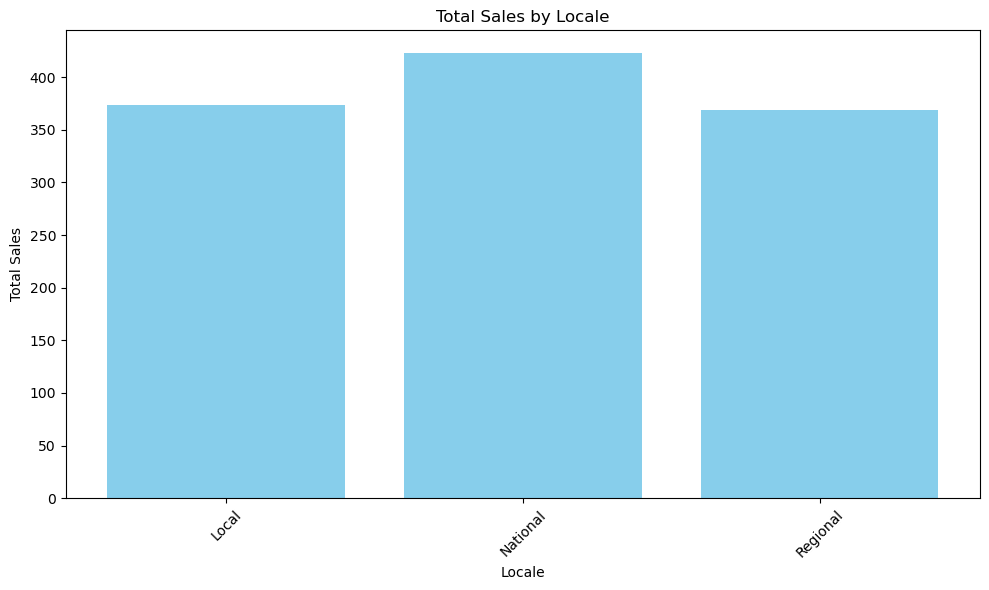

In [10]:
merged_df = pd.merge(df_train, df_holidays, on='date', how='left')
locale_sales = merged_df.groupby('locale')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(locale_sales['locale'], locale_sales['sales'], color='skyblue')
plt.title('Total Sales by Locale')
plt.xlabel('Locale')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

kaggle에서는 각 holiday의 locale별 판매량의 총합을 그래프로 나타냈는데, 내가 생각하기에는 그렇게 나타내면 당연히 holiday에서 많은 비율을 차지하는 national에서 가장 높게 나타날 것이기 때문에, 총합 부분을 평균으로 바꿔서 나타내보았고 결과는 위와같이 큰 차이를 보이지않았다.

## family(판매물품)와 sales 사이의 연관성

이 또한 원핫인코딩을 통해 판매물품별 구분을 한 뒤 시각화 할 것이다.

In [26]:
train_df = pd.read_csv("train.csv") 

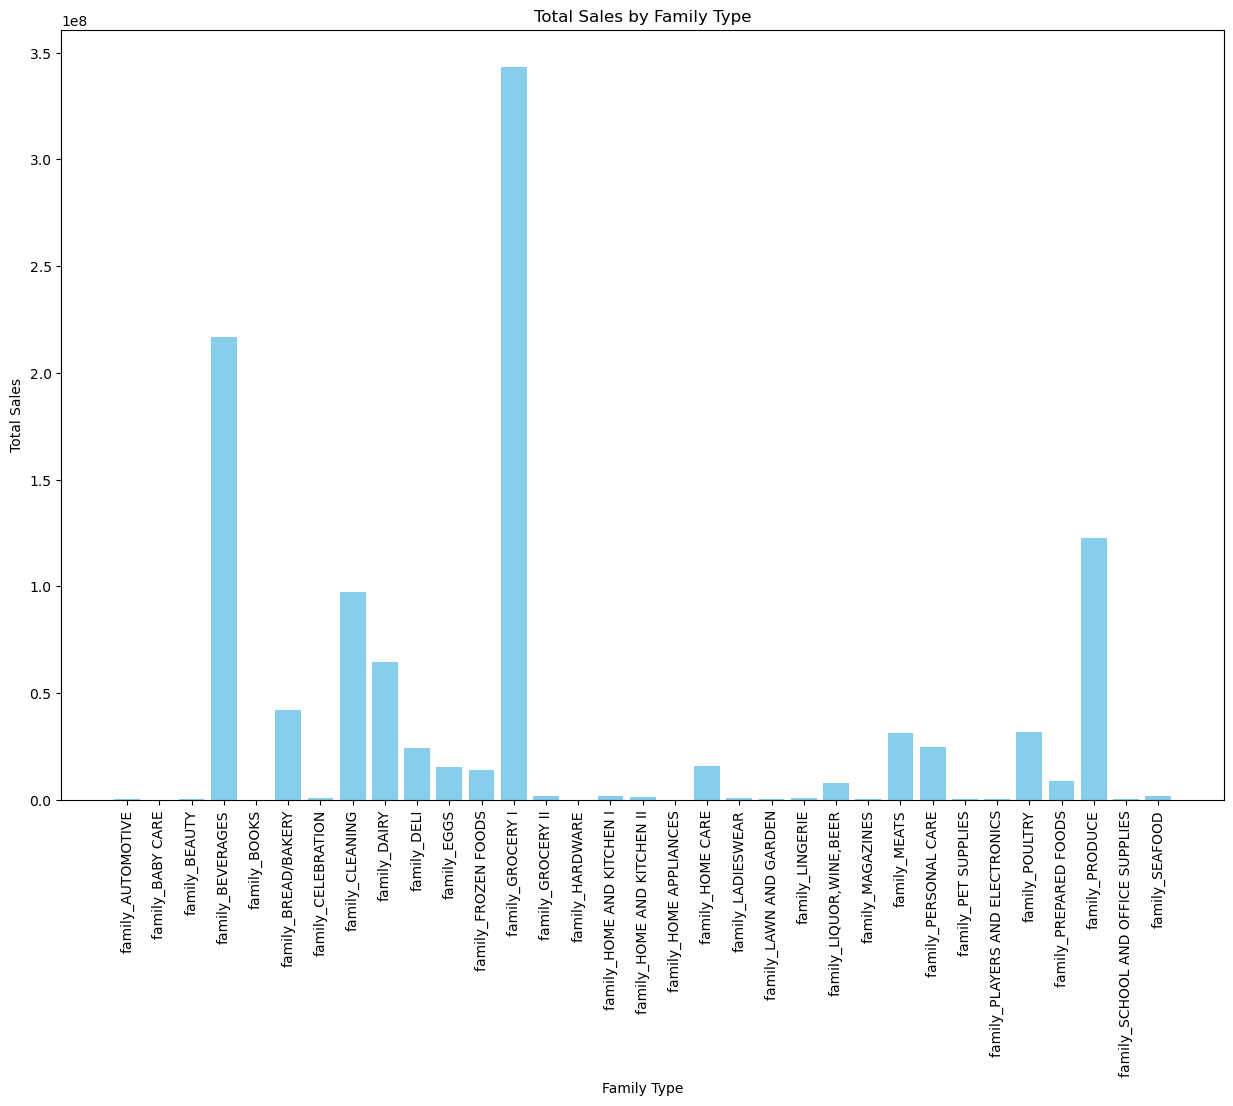

In [27]:
train_df = pd.get_dummies(train_df, columns=['family'])

family_types = [col for col in train_df.columns if col.startswith('family_')]
family_sales_sum = {}

for family_type in family_types:
    filtered_rows = train_df[train_df[family_type] == 1.0]
    family_sales_sum[family_type] = filtered_rows['sales'].sum()

fig, ax = plt.subplots(figsize=(15, 10)) 
ax.bar(family_sales_sum.keys(), family_sales_sum.values(), color='skyblue')
ax.set_title('Total Sales by Family Type')
ax.set_xlabel('Family Type')
ax.set_ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

한눈에 봐도 품목별로 판매량의 차이가 있음을 확인할 수 있을 것이다.

## 날짜별 판매량 차이

### 요일별 판매량

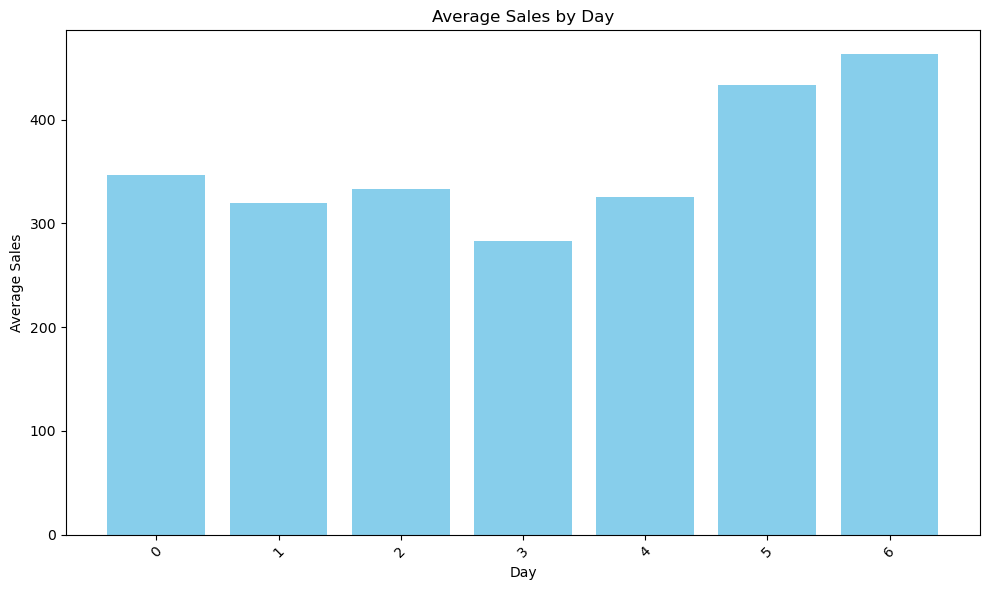

In [28]:
train_df['date'] = pd.to_datetime(train_df['date'])

# Add day of the week as new columns
# 0 is Monday
train_df['day_of_week'] = train_df['date'].dt.dayofweek

train_df[['id', 'date', 'day_of_week']]

day_avg_sales = train_df.groupby('day_of_week')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(day_avg_sales['day_of_week'], day_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by Day')
plt.xlabel('Day')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

평일보다는 주말의 판매량이 증가함을 알 수 있다.

### 월별 판매량

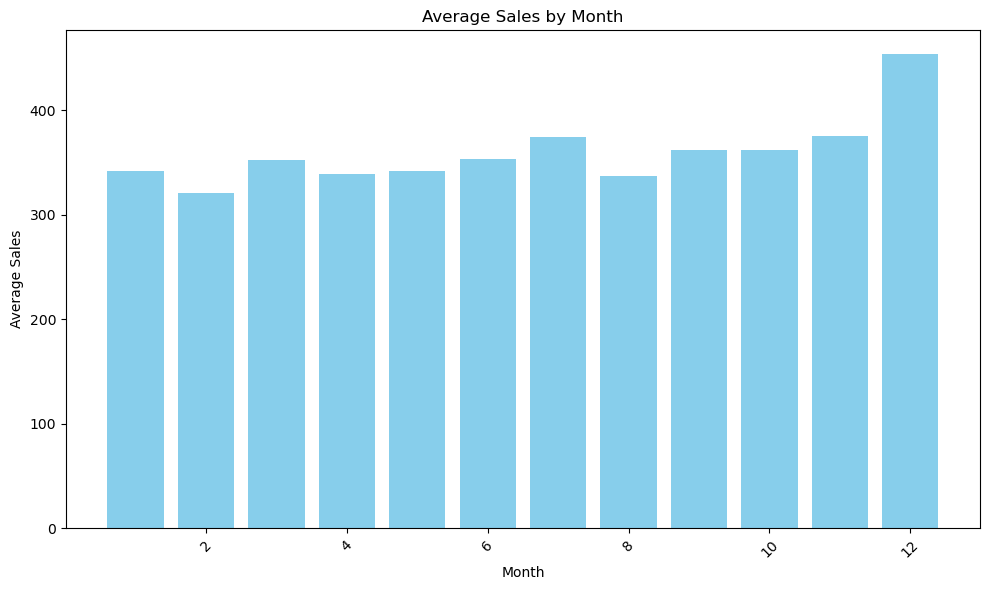

In [30]:
# Add month as new columns
train_df['month'] = train_df['date'].dt.month
month_avg_sales = train_df.groupby('month')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(month_avg_sales['month'], month_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

나머지는 고만고만하고 연말의 판매량이 가장 높음을 확인할 수 있다.

### 일별 판매량

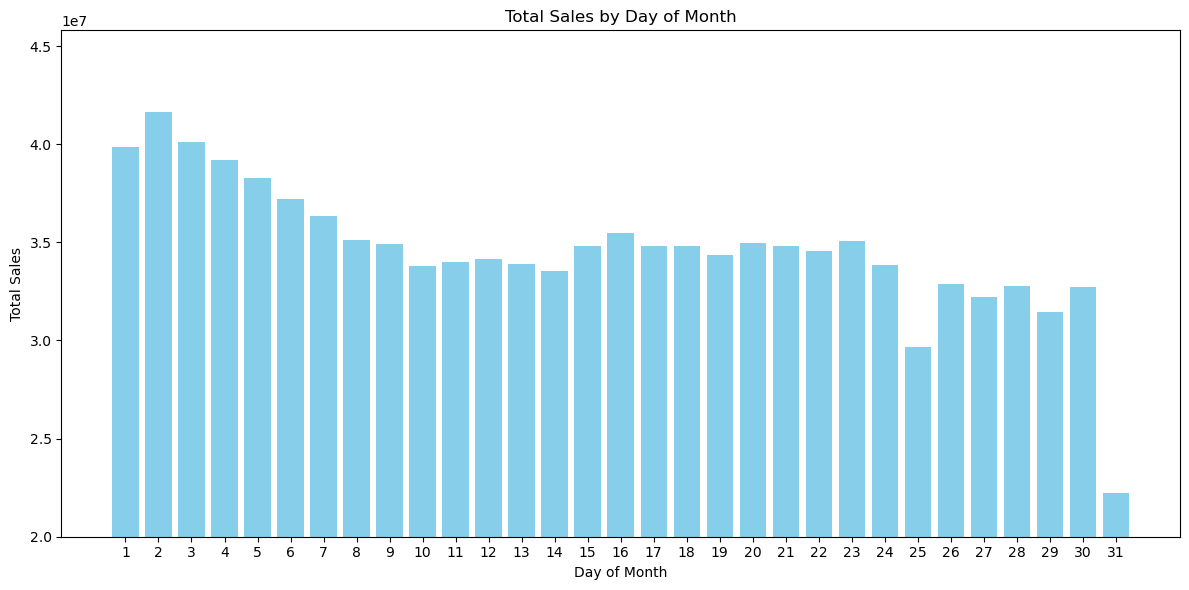

In [31]:
# Add day_of_month as new columns
train_df['day_of_month'] = train_df['date'].dt.day
day_of_month_sales_sum = train_df.groupby('day_of_month')['sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(day_of_month_sales_sum['day_of_month'], day_of_month_sales_sum['sales'], color='skyblue')
plt.title('Total Sales by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 32)) 
plt.ylim(20000000, day_of_month_sales_sum['sales'].max() * 1.1) 
plt.tight_layout()
plt.show()

31일은 없는날도 있다는 것을 감안해도 가장 작으며, 월초에 판매량이 높다가 월말로 갈 수록 판매량이 떨어짐을 확인할 수 있다.(월급날이 월초가 많으니까 월초에 판매량이 가장높고 갈수록 돈이 떨어져서 판매량도 떨어지는듯?)

## store과 sales 사이의 연관성

### store_nbr

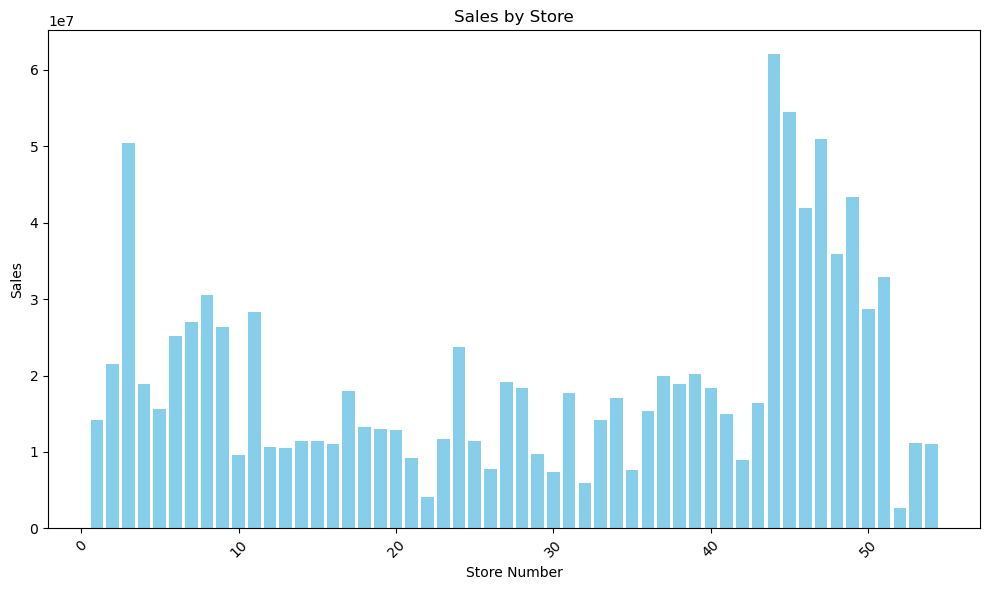

In [32]:
store_sales_sum = train_df.groupby('store_nbr')['sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(store_sales_sum['store_nbr'], store_sales_sum['sales'], color='skyblue')
plt.title('Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

가장 간단하게 가게의 고유번호(?)별 판매량만 나타내보아도 차이가있음을 확인할 수 있다.(44에서 가장 높음) 이제 좀 더 디테일하게 가게의 위치, 가게의 유형, 가게의 군집별 판매량 추이를 나타내보도록 하자.

### store type

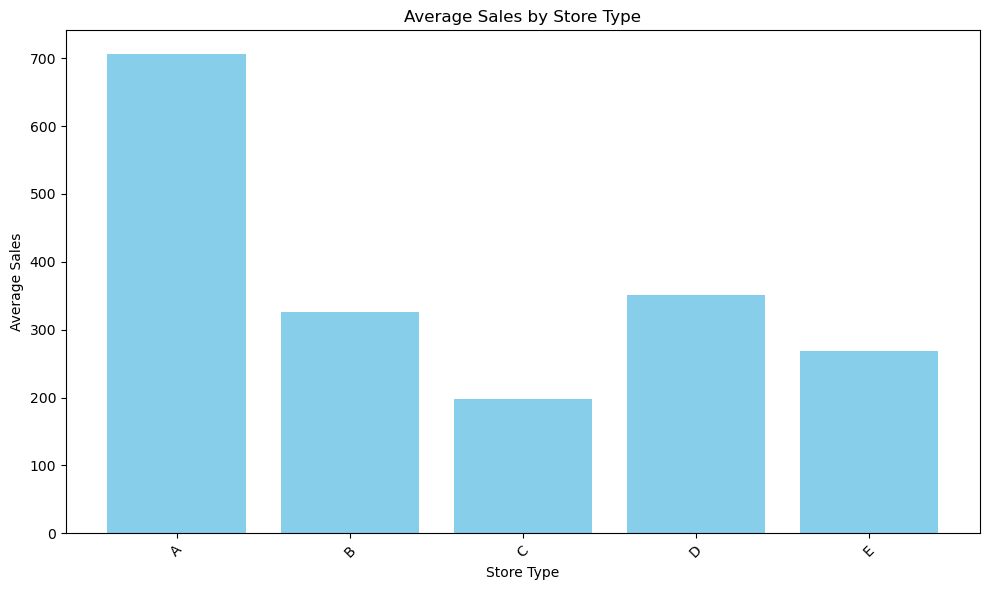

In [36]:
merged_df = pd.merge(train_df, df_stores, on='store_nbr', how='left')
type_avg_sales = merged_df.groupby('type')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(type_avg_sales['type'], type_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

가게 유형별 판매량 평균에 차이가 존재하며, 유형 A의 판매량 평균이 가장 높음을 확인할 수 있다.(유형 A,B,C,D,E는 각 각 무엇을 나타내는가?)

### store cluster

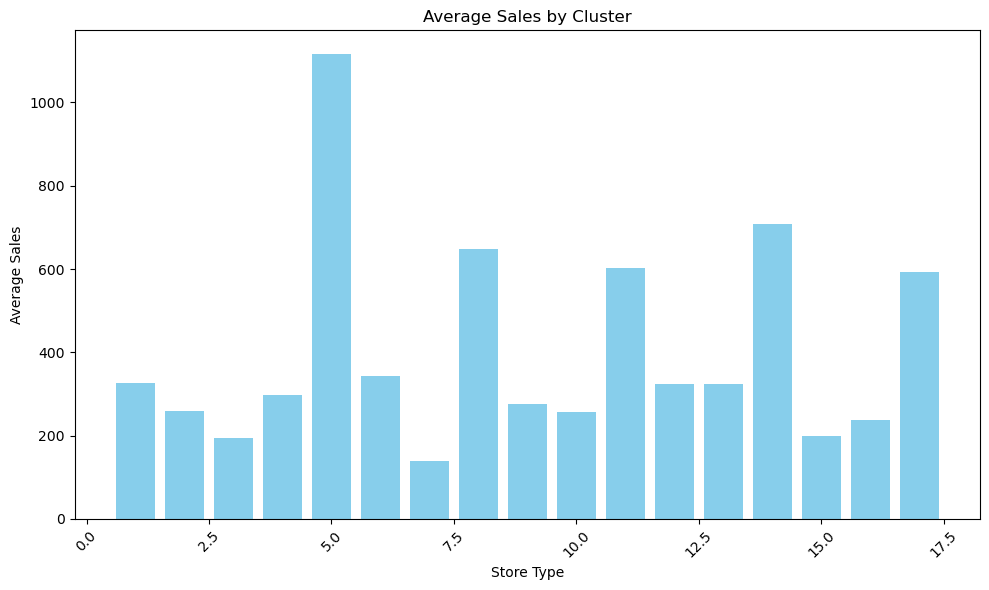

In [37]:
type_avg_sales = merged_df.groupby('cluster')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(type_avg_sales['cluster'], type_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by Cluster')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

가게 군집별로도 판매량 평균에 차이가 있음을 확인할 수 있고, 5번째 군집에서 판매량 평균이 가장 높게 나타났다.(군집 5의 특징은 무엇인가?)

### store city

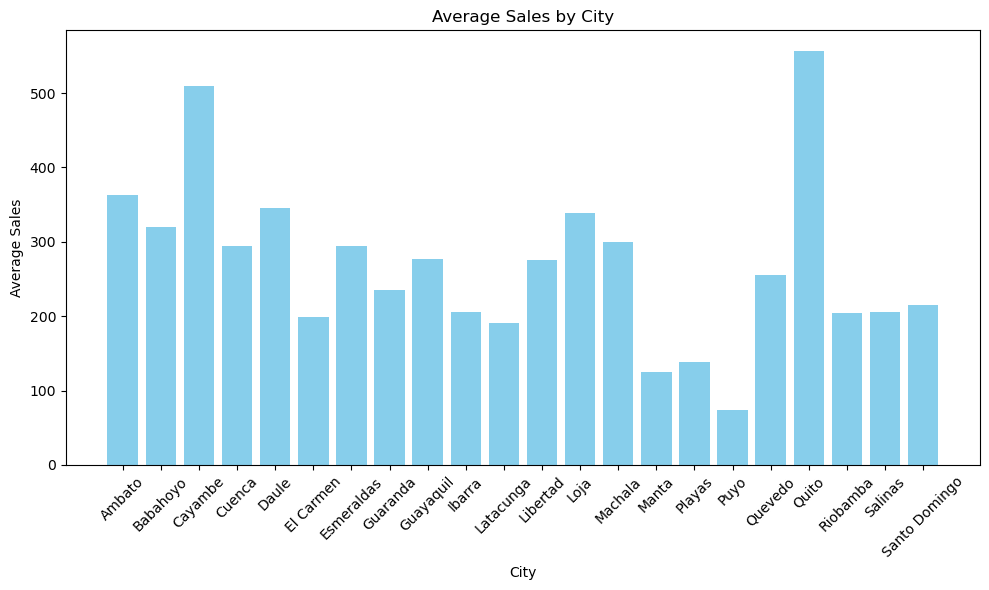

In [38]:
city_avg_sales = merged_df.groupby('city')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(city_avg_sales['city'], city_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by City')
plt.xlabel('City')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

가게가 위치하는 도시별로도 판매량 평균에 차이를 보였고, Quito에서의 판매량 평균이 가장 높게 나타났다. Quito는 에콰도르의 수도로 인구가 가장 많이 분포해있는 Guayaquil 다음으로 인구가 많이 분포해있는 도시이다.(인구가 가장많은 Guayaquil에서의 판매량이 그리 높지않은 것으로 보아 인구는 판매량과 큰 연관성이 없다고 봐야하는 것일까? 에콰도르에서 인구가 많이 분포해있는 몇 개의 도시에 대한 판매량 평균을 살펴본 결과 santo domingo, riobamba와 같이 판매량이 저조하게 나타나있는 도시가 있는 반면 ambato처럼 그리 낮지않은 판매량을 가진 도시도 있었다. 즉, 인구와 판매량간에는 그리 연관성이 있어보이지는 않았다. 그렇다면 도시마다 판매량이 다르게 나타나는 이유는 무엇일까?) 그 다음으로 판매량이 높은 cayambe는 quito근처에 위치해있는 농업도시이다.

### store state

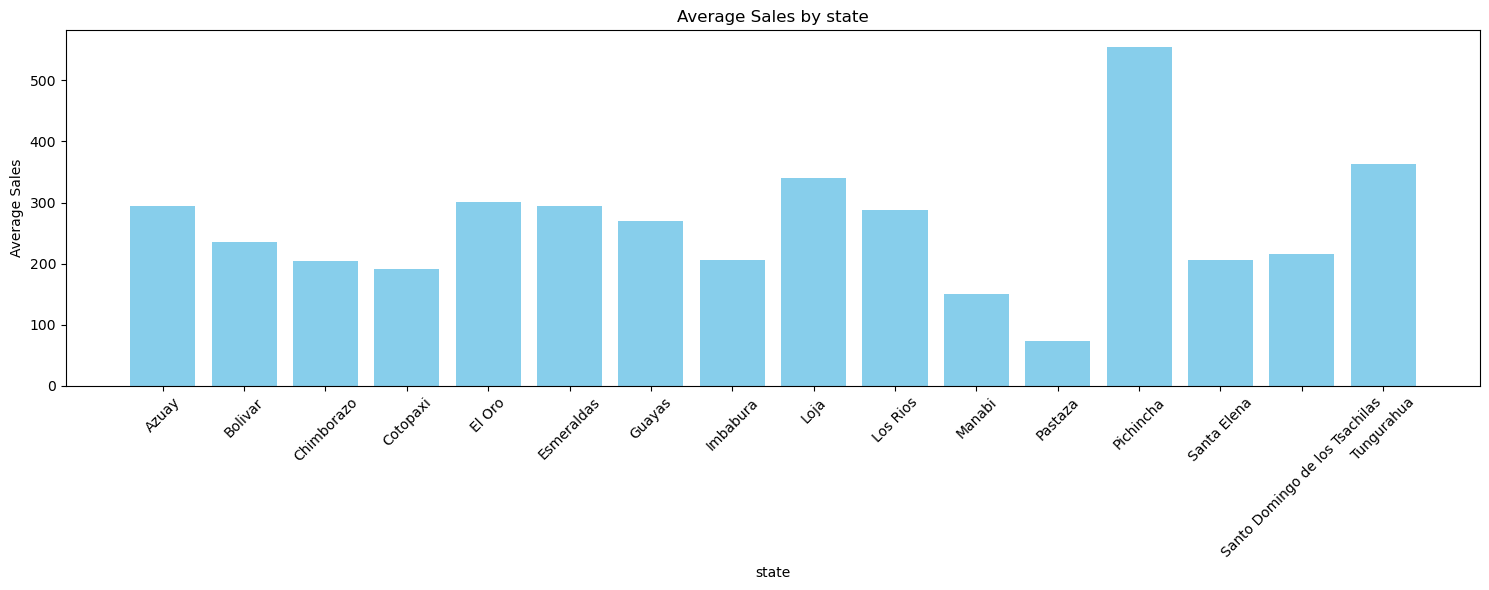

In [59]:
city_avg_sales = merged_df.groupby('state')['sales'].mean().reset_index()

plt.figure(figsize=(15, 6))
plt.bar(city_avg_sales['state'], city_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by state')
plt.xlabel('state')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

일단 넣어두긴했는데 city의 정보와 중복되는 것 같아서 딱히 신경 쓸 필요는 없어보인다.

### 다시 살펴보기

앞서 가장 높은 판매량을 보였던 지표가 어떤 특징을 가지고있는지 확인해볼 것이다.

In [61]:
df_stores.loc[df_stores.cluster==5,:]

,store_nbr,city,state,type,cluster
43,44,Quito,Pichincha,A,5


하나의 값 밖에 없지만 가장 높은 지표를 가졌던 것을 모두 가지고있는 값이다.

In [62]:
df_stores.loc[df_stores.type=='A',:]

,store_nbr,city,state,type,cluster
43,44,Quito,Pichincha,A,5
44,45,Quito,Pichincha,A,11
45,46,Quito,Pichincha,A,14
46,47,Quito,Pichincha,A,14
47,48,Quito,Pichincha,A,14
48,49,Quito,Pichincha,A,11
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11


type A의 특징이 무엇인지는 잘 모르겠으나, 인구지표가 높은 도시들로 구성되어있는 것을 알 수 있었다.

In [63]:
df_stores.loc[df_stores.city=='Quito',:]

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15
16,17,Quito,Pichincha,C,12


city와 state와 type이 모두 같아도 cluster가 다른것이 존재하고, 마찬가지로 city와 state는 같지만 type이 제각각인 것을 보아 알수없는 다른 기준에 의해서 type과 cluster가 결정됨을 알 수 있었다.

# 팀별 분석 방법

1. 시계열성을 사용해 분석 ~ 시간을 가져와 분석(date 즉, 년/월/일을 factor처럼 넣어 범주형자료처럼 분석)
2. boosting model, tree model(시계열성 고려X)
3. 시계열 model 사용, deep learning model 위주로 사용할 것임(model에 대한 논문 읽어보고 논의 후 구현)
4. 앙상블 학습(시계열 모델과 시계열을 고려하지 않은 boosting model의..)
5. python 사용, github 이용할 계획(잘 모르지만 분석한거 공유하는데 사용할 것임)

1. deep learning 보다는 EDA/시각화를 열심히 해볼 것임
2. 그래서 만나서 할거라 자주 학교 올 수 있는 사람 위주였으면 좋겠음
3. model보다는 데이터 자체에 대한 분석위주로 할 것임

# EDA

- holiday 중 transfer같은 것을 어떻게 처리할 것인가 -> 공휴일과 공휴일이 아닌 날을 구분하는 방법 
- oil data에서 결측치 처리를 어떻게 할 것이고, 사실상 사용할 수 없어보이긴 하지만 shift를 시켜 사용할 수 있는 방법을 고안해보자.
- store type이 뭘지 생각해보자.
- 전체적으로 판매량과 관련이 있는 데이터가 무엇일지 생각해보고, 사회적인 정세(ex.oil shock)가 어떤 영향을 끼쳤는지도 살펴보자.